In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df=pd.read_csv("/content/Startup_Scoring_Dataset.csv")

In [6]:
df.head()

,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   startup_id               100 non-null    object
 1   team_experience          100 non-null    int64 
 2   market_size_million_usd  100 non-null    int64 
 3   monthly_active_users     100 non-null    int64 
 4   monthly_burn_rate_inr    100 non-null    int64 
 5   funds_raised_inr         100 non-null    int64 
 6   valuation_inr            100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB


In [8]:
df.shape

(100, 7)

In [9]:
df.describe()

,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
count,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02
mean,5.910000,548.500000,52002.670000,5.271927e+06,2.256808e+07,2.316022e+08
std,2.871296,270.025046,29193.444748,2.801648e+06,1.633037e+07,1.388826e+08
min,1.000000,14.000000,954.000000,1.663810e+05,1.188340e+05,1.007064e+07
25%,3.000000,346.750000,26729.250000,2.928578e+06,5.996659e+06,1.121723e+08
50%,6.000000,578.000000,52472.500000,5.277296e+06,2.214305e+07,2.437296e+08
75%,8.000000,755.000000,74684.750000,7.694987e+06,3.549996e+07,3.198588e+08
max,10.000000,996.000000,98606.000000,9.931393e+06,4.965544e+07,4.978948e+08


In [10]:
print(df.isnull().sum())

startup_id                 0
team_experience            0
market_size_million_usd    0
monthly_active_users       0
monthly_burn_rate_inr      0
funds_raised_inr           0
valuation_inr              0
dtype: int64


##### "Checked for null values across all columns. The dataset is clean, with no missing entries. Therefore, no imputation or data cleaning was required before preprocessing."

## Visualisations

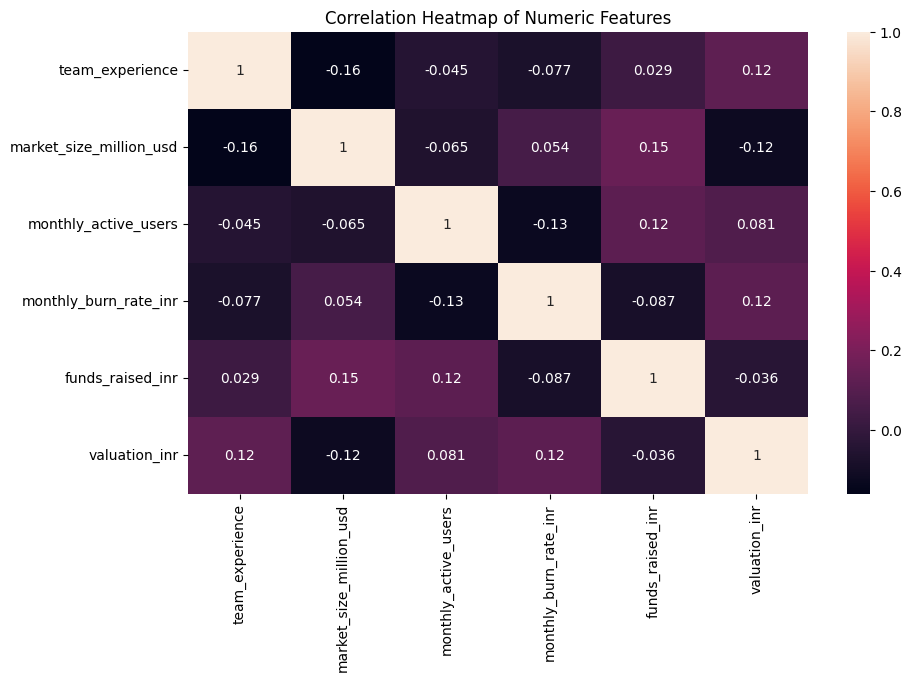

In [11]:
num_df=df.select_dtypes(include=['number'])
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(),annot=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

###Correlation Heatmap of Numeric Features


*   The correlation matrix helps identify relationships between features
*   For example, we might expect 'funds_raised_inr' and 'valuation_inr' to be positively correlated.
*   We exclude non-numeric columns (like 'startup_id') to avoid errors.
*   This insight can guide our feature weighting in the scoring formula.

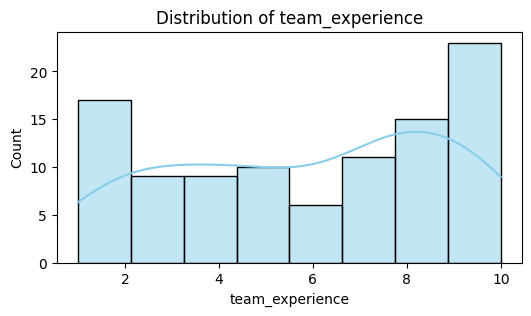

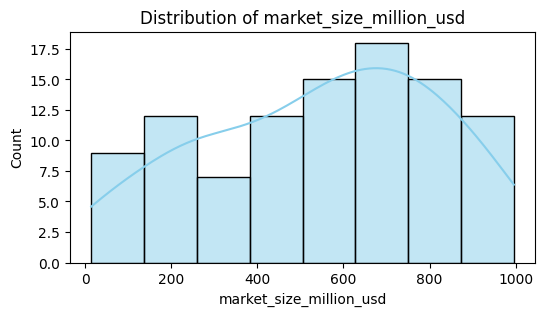

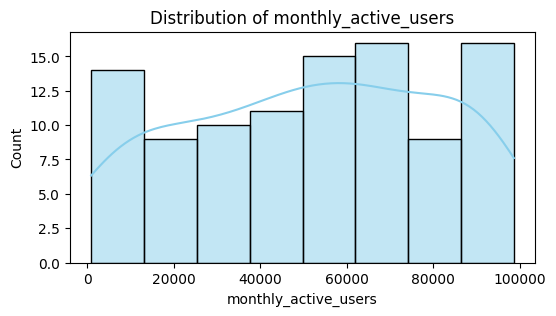

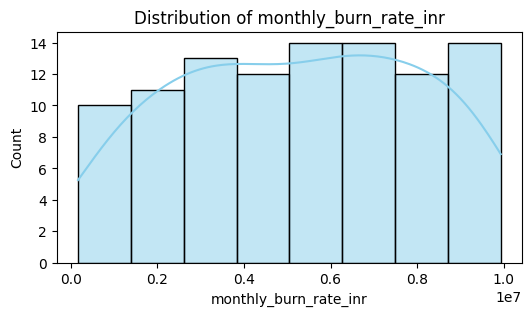

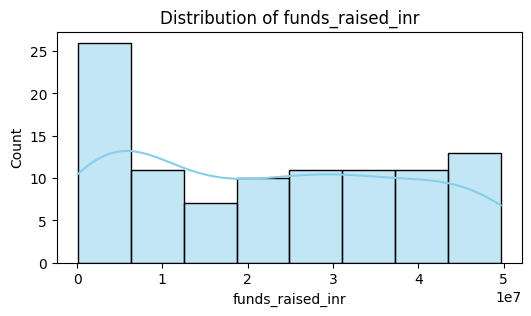

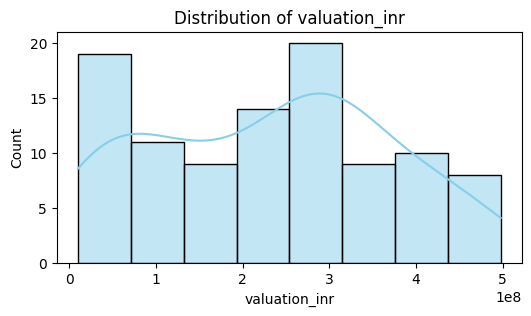

In [12]:
### plot distribution for numerical columns
features= ['team_experience', 'market_size_million_usd', 'monthly_active_users',
            'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr']

for col in features:
  plt.figure(figsize=(6,3))
  sns.histplot(df[col],kde=True,color='skyblue')
  plt.title(f"Distribution of {col}")
  plt.show()

## Data Processing

In [13]:
#Function to Normalize
def normalize(col):
  return (col-col.min())/(col.max()-col.min())

In [14]:
df_norm=df.copy()

# List of features to normalize
features = ['team_experience', 'market_size_million_usd', 'monthly_active_users',
            'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr']

for col in features:
  if 'burn_rate' in col:
   df_norm[col]= 1-normalize(df_norm[col])  # invert burn rate: high = bad
  else:
    df_norm[col]=normalize(df_norm[col])


#viewing first few rows after normalization
df_norm[features].head()


,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,0.666667,0.789206,0.669162,0.393230,0.082061,0.518992
1,0.333333,0.941955,0.347274,0.084439,0.011052,0.333843
2,0.777778,0.028513,0.744235,0.114112,0.010706,0.621166
3,0.444444,0.043788,0.949320,0.364283,0.404435,0.606400
4,0.666667,0.507128,0.616813,0.930815,0.000000,0.153220


### Normalized all numeric features using Min-Max scaling.

*   Inverted 'monthly_burn_rate_inr' to reflect negative correlation (high burn = bad).
*   Now all features are scaled between 0 and 1, ready for scoring



### We'll assign weights to each feature, based on how important they are for startup success. Here's a simple but logical weighting scheme

In [19]:
# ✅ Define weights for each feature
weights = {
    'team_experience': 0.15,
    'market_size_million_usd': 0.20,
    'monthly_active_users': 0.25,
    'monthly_burn_rate_inr': 0.10,
    'funds_raised_inr': 0.15,
    'valuation_inr': 0.15
}
df_norm['startup_score']=sum(df_norm[col]*weights[col] for col in weights)
df_norm['startup_score']*=100   # Scale to 0–100
df_norm[['startup_id','startup_score']].sort_values(by='startup_score',ascending=False).head(10)

,startup_id,startup_score
5,S006,81.037331
76,S077,77.047933
44,S045,75.655026
32,S033,74.936099
12,S013,74.675295
28,S029,73.114982
96,S097,70.037973
11,S012,69.810579
7,S008,69.671483
42,S043,69.554850


### Top 10 startups based on final score
*   These startups show the strongest potential according to our scoring model


In [20]:
#Above 10
high=df_norm[['startup_id','startup_score']].sort_values(by='startup_score',ascending=False).head(10)
print((" Highest Scoring Startup:\n"))
print(high)
# Below 10
low=df_norm[['startup_id','startup_score']].sort_values(by='startup_score',ascending=True).head(10)
print((" Lowest Scoring Startup:\n"))
print(low)

 Highest Scoring Startup:

   startup_id  startup_score
5        S006      81.037331
76       S077      77.047933
44       S045      75.655026
32       S033      74.936099
12       S013      74.675295
28       S029      73.114982
96       S097      70.037973
11       S012      69.810579
7        S008      69.671483
42       S043      69.554850
 Lowest Scoring Startup:

   startup_id  startup_score
54       S055      19.094732
97       S098      26.158777
22       S023      26.262269
57       S058      28.567332
83       S084      30.144740
78       S079      30.430187
50       S051      32.321262
60       S061      32.964227
16       S017      33.527899
73       S074      33.662372


## Why Startup S006 Scored High:


*   Strong team experience and monthly active users
*   Large market size, solid funding, and good valuation.
*   Balanced across all important metrics → high composite score.
*  Controlled burn rate due to inverted normalization.

## Why Startup S055 Scored Low:

*   Very low traction (monthly active users).
*   Minimal funding and valuation, indicating weak investor confidence.
*   Possibly high burn rate relative to resources.
*   Despite maybe a capable team, the business outlook looks constrained.






# Distribution Histogram of All Startup Scores

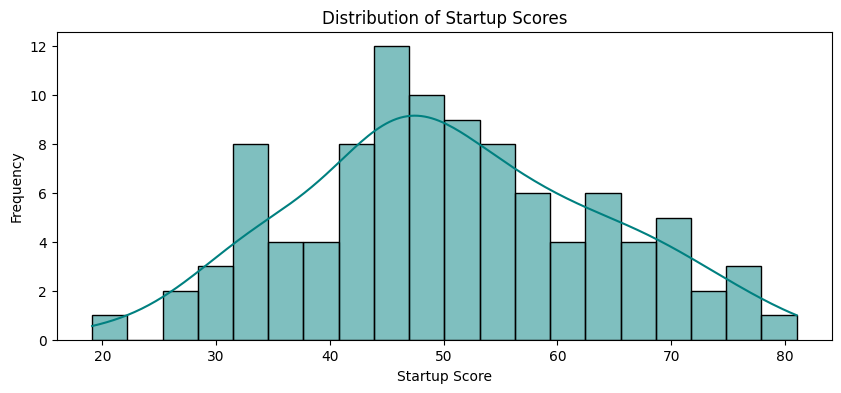

In [23]:
# Histogram helps visualize how the startups are spread out based on the composite score
plt.figure(figsize=(10,4))
sns.histplot(df_norm['startup_score'],bins=20,kde=True,color='teal')
plt.title("Distribution of Startup Scores")
plt.xlabel("Startup Score")
plt.ylabel("Frequency")
plt.show()

# Bar Chart of Top 10 Startups

/tmp/ipython-input-25-4122960920.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='startup_score', y='startup_id', data=top_10, palette='viridis')


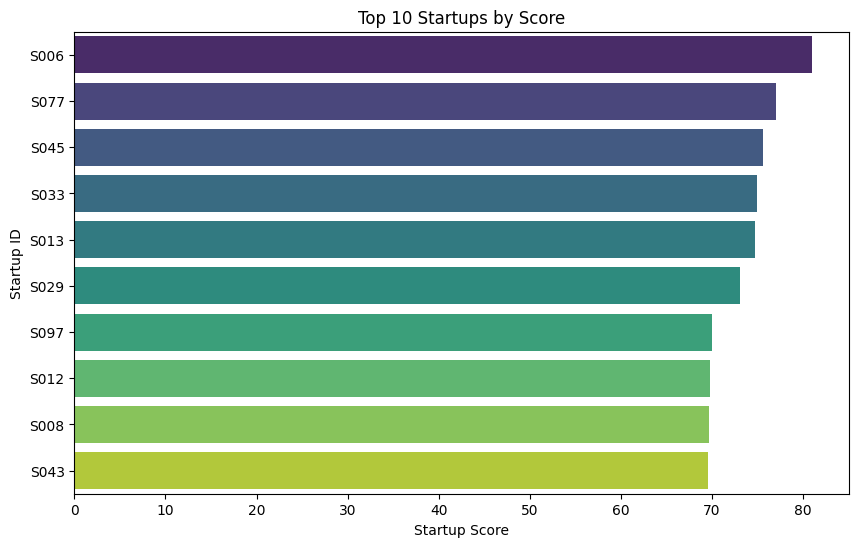

In [25]:
# Highlights the highest performers in a clear visual
top_10 = df_norm.sort_values(by='startup_score', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='startup_score', y='startup_id', data=top_10, palette='viridis')
plt.title('Top 10 Startups by Score')
plt.xlabel('Startup Score')
plt.ylabel('Startup ID')
plt.show()

# Correlation Heatmap (Numeric Features Only)

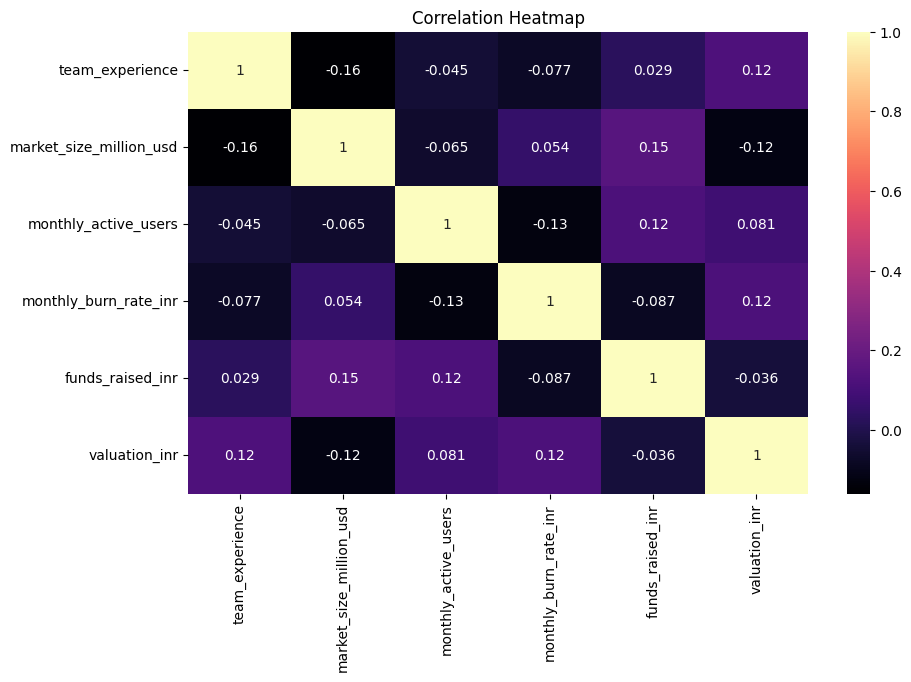

In [29]:
# Reveals how strongly features relate to one another (e.g., funding ↔ valuation)
numeric_df=df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='magma')
plt.title('Correlation Heatmap')
plt.show()

#  Correlation Heatmap of Numeric Features:


*  This heatmap helps us identify relationships between input features.
*  For example, 'funds_raised_inr' and 'valuation_inr' are expected to be positively correlated, as higher funding often leads to a higher valuation.
*  Strong correlations can guide our feature weighting and provide business insights.
*  Non-numeric columns like 'startup_id' are excluded to avoid errors.

In [30]:
df_norm.sort_values(by='startup_score', ascending=False).to_csv("Startup_Score_Ranked.csv", index=False)

In [31]:
from google.colab import files
files.download("Startup_Score_Ranked.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion
We built a startup scoring model using normalized features and weighted metrics like traction, market size, and funding.
Burn rate was inverted, as higher values indicate poor financial health.
Top startups showed strong traction and balanced funding; bottom ones lacked user base or burned too much cash.
Visuals supported insights, and the model proved useful for evaluating startup potential.
This approach can guide investors or accelerators in early-stage decision-making.

